# Clustering Tutorial
By: Patricia Ornelas Jauregui

## What is clustering?
Clustering is a technique used to group a dataset into K clusters. This unsupervised machine learning algorithm aims to make each cluster contain similar data points by minimizing the variance in each cluster. There are a wide variety of approaches to clustering. In this tutorial, we will cover 2 specific approaches: K-means and spectral clustering. 

Clustering has many applications including:
- Recommender systems that group together similar users in order to recommend them similar content
- Image segmentation
- Image compression
- Search result grouping

## K-Means Clustering
One approach to clustering is the K-Means Clustering algorithm. Here’s how it works:

1. Select K, the number of clusters you want to identify. To determine an appropriate choice of K when the number of clusters are unknown, use the elbow method:
    - Try different values of K and calculate the WCSS (Within-Cluster Sum of Square). WCSS is the sum of squared distance between each point and the centroid in a cluster. Plot each potential K value against its corresponding WCSS. As K increases, the WCSS value will start to decrease, forming an elbow-like shape on the plot. The optimal choice of K is at the point of the biggest drop of WCSS before the plot starts to move almost parallel to the X-axis as shown in the example below.
    
    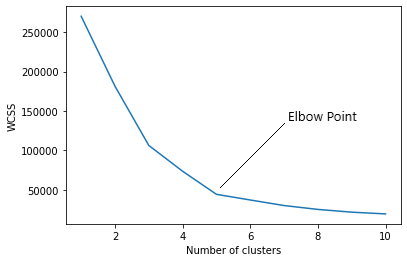
2. Randomly generate K points as the initial centroids of the clusters.
3. Measure the distance between each data point and each centroid. Assign each data point to its closest centroid.
4. Recompute the centroid of each cluster based on the data point memberships.
5. Repeat steps three and four to reassign data points to clusters based on the new centroid locations. This iterative algorithm has two potential stopping conditions:
     - The centroids no longer change. In other words, no data points are reassigned to different clusters.
     - A predetermined maximum number of iterations has been met.

### Example: Reducing the color space of an image using K-Means
In the following example, we will import an image and use K-means clustering to reduce the color space needed to display that image. We will show that clustering allows us to group similar colors. The color space is reduced from close to 16 million to just 16! The resulting image in the reduced color space still generally looks like the original, but it has less color variability. 

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import matplotlib.image as image
%matplotlib inline
plt.style.use("ggplot")

from skimage import io
from skimage.io import imread, imshow
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns; sns.set()
import os

In [2]:
# plot the pixels in the image where each cluster has its own color
def plot_pixels(img, title, colors=None, N=10000):
    if colors is None:
        colors = img
    
    # choose a random subset
    rand_state = np.random.RandomState(0)
    i = rand_state.permutation(img.shape[0])[:N]
    colors = colors[i]
    R, G, B = img[i].T
    
    # plot red vs blue
    fig, ax = plt.subplots(1, 3, figsize=(16, 4))
    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))
    
    # plot red vs green
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))
    
    # plot blue vs green
    ax[2].scatter(B, G, color=colors, marker='.')
    ax[2].set(xlabel='Blue', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

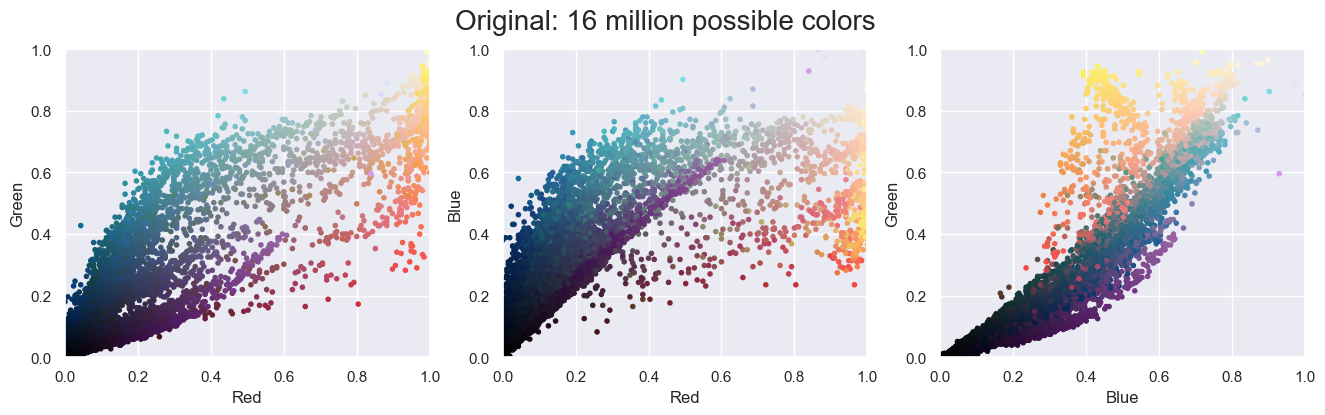

In [3]:
# plot the RGB values (2 at a time)
dog = imread('images/landscape.jpeg')
img = dog / 255.0 
img = img.reshape(int(dog.size/3), 3)

plot_pixels(img, title='Original: 16 million possible colors')

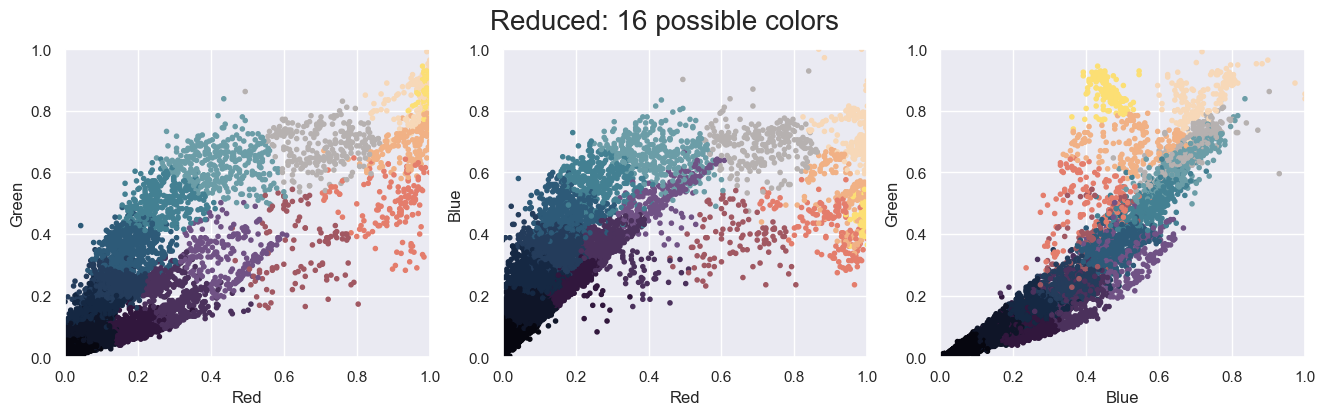

In [4]:
# run K-Means clustering on the image with 16 clusters
k = 16
kmeans = MiniBatchKMeans(k)
kmeans.fit(img)

# recolor the original image 
new_colors = kmeans.cluster_centers_[kmeans.predict(img)]

# plot the reduced RGB values (2 at a time)
plot_pixels(img, colors=new_colors,
            title="Reduced: 16 possible colors")

These plots of the reduced color space shows much less of a gradient because of the color grouping.

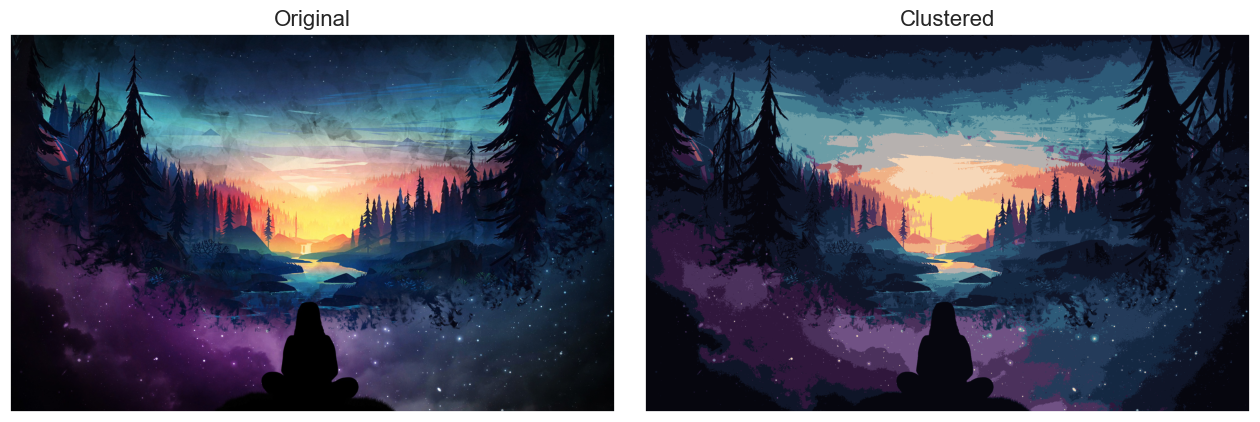

In [5]:
# show the reduced-color image
dog_recolored = new_colors.reshape(dog.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(dog)
ax[0].set_title('Original', size=16)
ax[1].imshow(dog_recolored)
ax[1].set_title('Clustered', size=16);

## Spectral Clustering
This algorithm generally outperforms K-means. At it's core, spectral clustering considers each data point to be a graph node. Then, the clustering becomes a graph partitioning problem.

Here’s how it works:
1. Create a similarity graph with one of these two approaches:

    - K-Closest Neighbors: Connect each point to its K nearest neighbors

    - ε Neighborhood: Compute pairwise distance between any two points and connect each point to all other points which have distance smaller than a predefined threshold ε.

    Toy example:

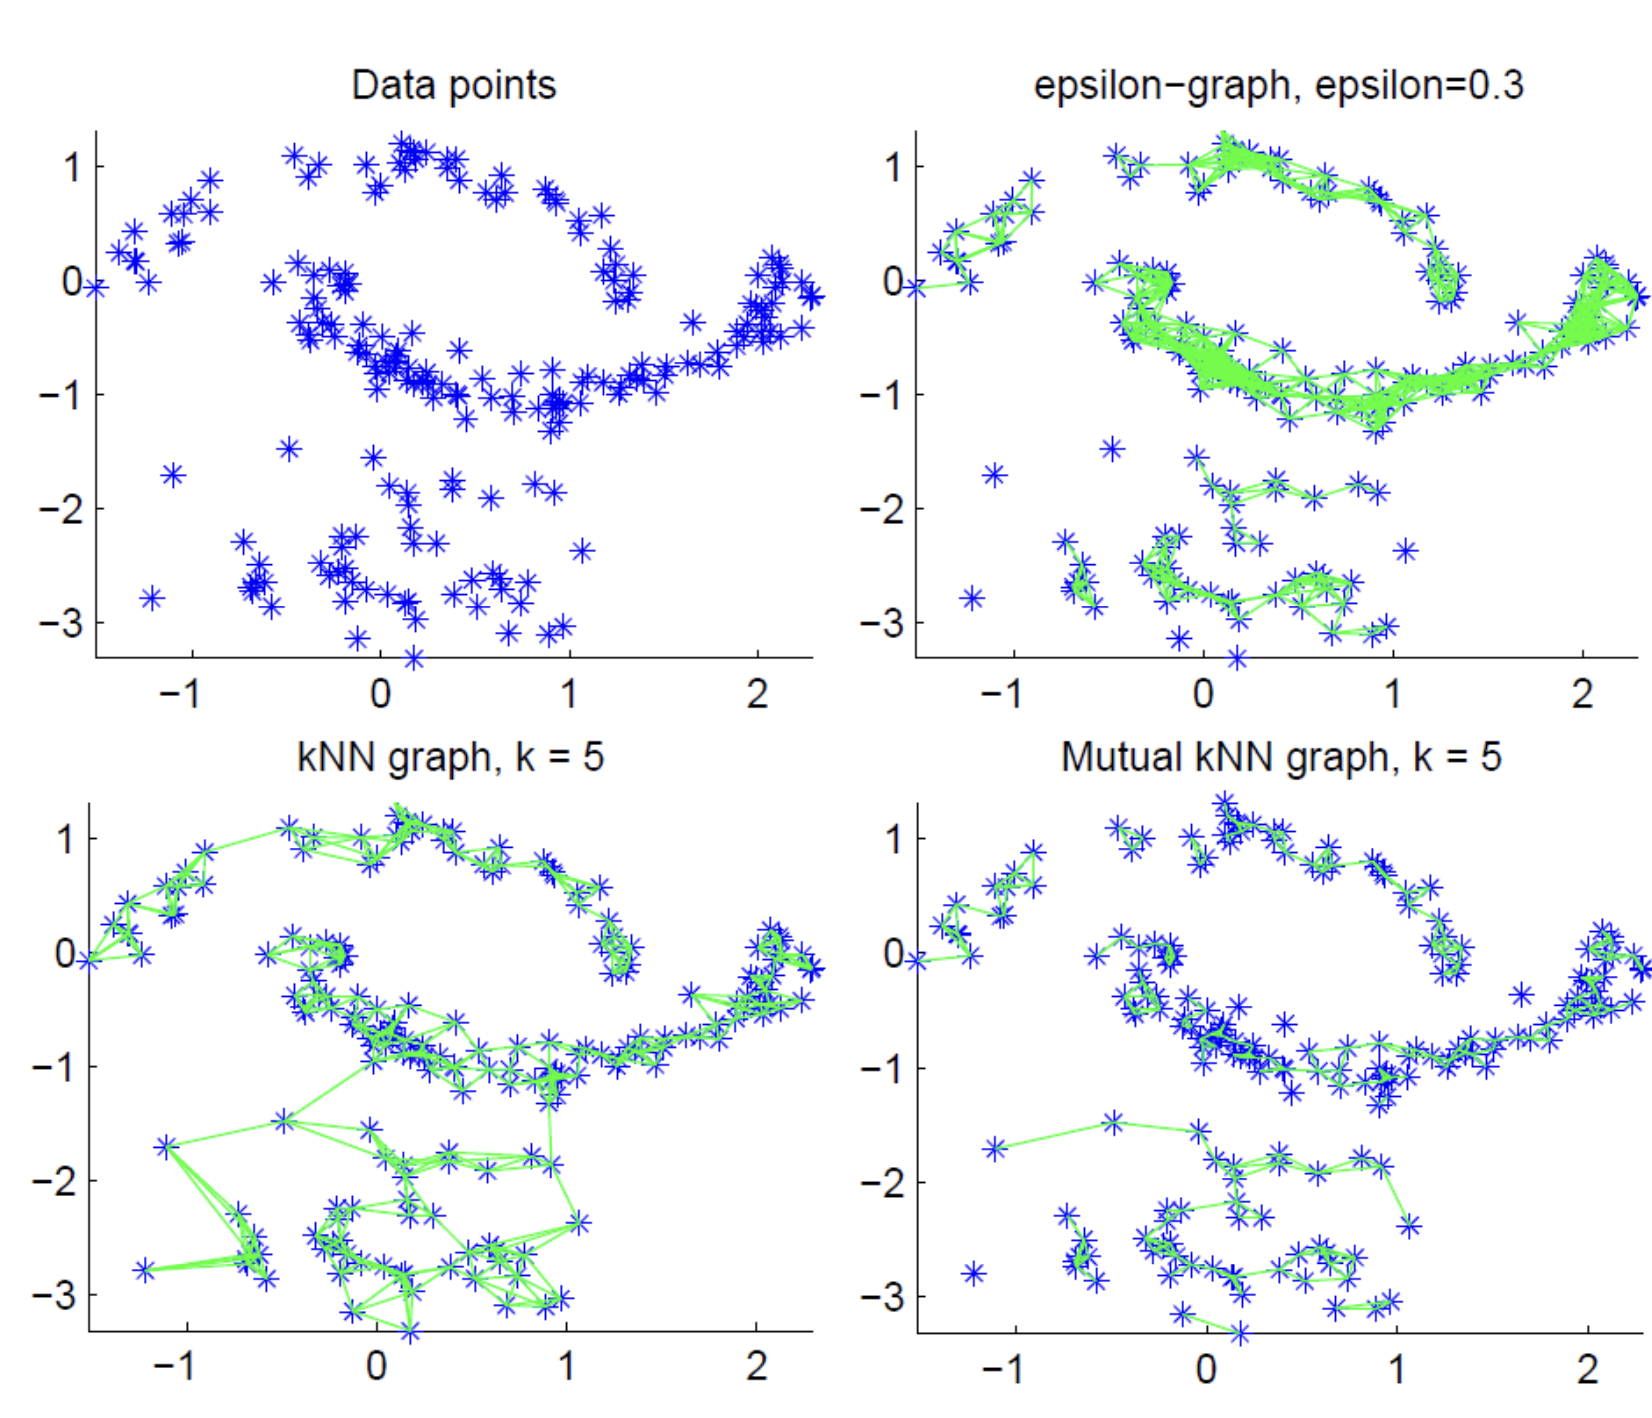

In [13]:
from IPython import display
display.Image("graphs.png")

2. Project the data onto a lower dimensional space.

    a) Represent this graph as its adjacency matrix A, where each entry tells us about the absence or presence of an edge between the nodes of the corresponding row and column (i.e. if the entry in row 1 and column 2 is 1, it would indicate that node 1 is connected to node 2).

    b) Represent the graph as its degree matrix D. The number of edges connected to a node is its degree. This can easily be computed by taking the sum of the node’s row in the adjacency matrix A.

    c) Calculate the Graph Laplacian L as D-A. This matrix has several properties that make it useful for spectral clustering.

    d) Compute the eigen vectors of the matrix L and take the top k where k <= d. These vectors form the columns a matrix called V.

    e) This allows us to create embeddings of the original dimensional space using the top k eigen dimensions of variation. 

    f) Normalize the rows of V to get the matrix W. Normalizing refers to the process of dividing the vector by its size.

3. Cluster the Data. Perform the steps of K-means on each row of W as detailed at the beginning of this report.

### Example: Reducing the color space of an image using spectral clustering
In the following example, we will use the digits dataset and perform spectral clustering on the image of a digit. The goal is to reduce the colors needed to represent the image of the digit. We can see that the resulting digit still looks the distinguishable when the digit is 0.

The sklearn library takes care of the steps of spectral clustering and makes it easy to implement this algorithm on a given dataset.

In [6]:
# import necessary libraries
from sklearn.feature_extraction.image import img_to_graph
from sklearn.cluster import spectral_clustering
from sklearn.datasets import load_digits

In [7]:
# load dataset
digit = 0
img = load_digits().images[digit].astype(float)
mask = img.astype(bool)

In [8]:
# create a graph from the image data
graph = img_to_graph(img, mask=mask)
graph.data = np.exp(-graph.data/graph.data.std())

In [9]:
# run spectral clustering with 3 clusters
k = 3
labels = spectral_clustering(graph, n_clusters=k)
label_im = -np.ones(mask.shape)
label_im[mask] = labels

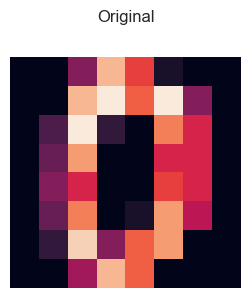

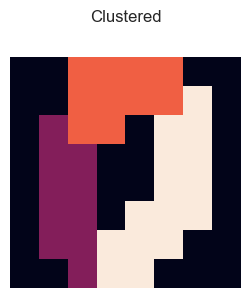

In [10]:
# plot original image
plt.figure(figsize=(9,3))
# matshow visualizes a 2D matrix or array as color-coded image
plt.matshow(img, False) 
plt.gca().axis('off')
plt.title('Original')
plt.show()

# plot segmented/clustered/reduced image
plt.figure(figsize=(9,3))
plt.matshow(label_im, False)
plt.gca().axis('off')
plt.title('Clustered')
plt.show()

## Comparing Spectral and K-Means Clustering
Both of these algorithms can have different results depending on their initial centroids.

### Assumptions
- K-means assumes that the clusters have convex boundaries. Unlike K-Means, spectral clustering is not limited by the shape of the clusters and their relation to each other. An example of this is shown below:

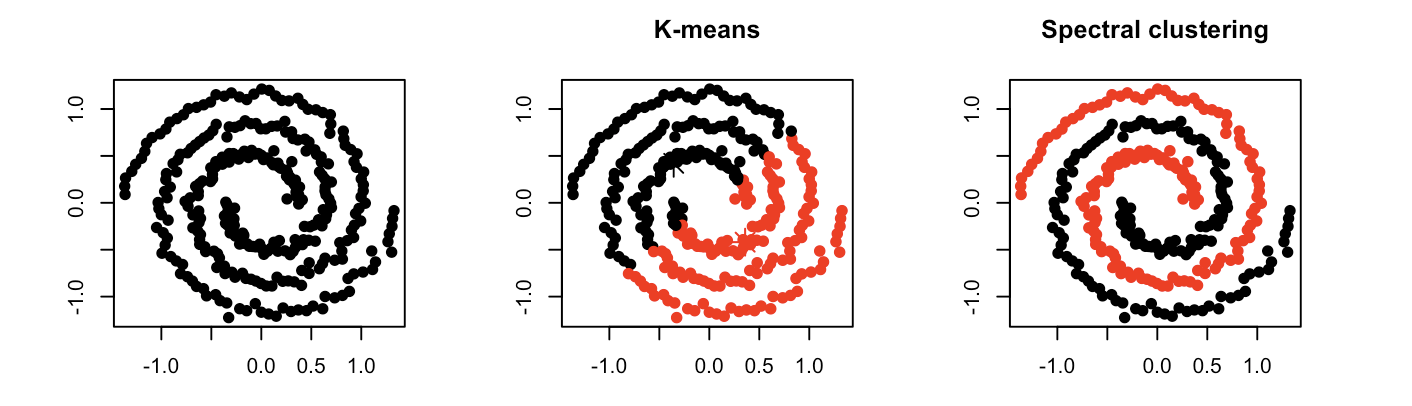

In [11]:
from IPython import display
display.Image("shapes.png")

### Complexity
K-Means:
O(t * k * n * d)
- n is the number of d-dimensional points
- k is the number of clusters
- t is the number of predefined iterations

Spectral Clustering:
O(n^3)
- n is the number of data points
- It can be costly to compute the eigenvectors and eigenvalues of a large matrix, so this algorithm isn't scalable

## References
- [K-Means Clustering Example](https://www.kaggle.com/code/brendan45774/k-means-clustering-image-compression)
- [Spectral Cluster Graph Image](https://cse.buffalo.edu/~jing/cse601/fa12/materials/clustering_spectral.pdf)
- [Digit Image Segmentation](https://subscription.packtpub.com/book/big-data-and-business-intelligence/9781785282287/11/ch11lvl1sec156/segmenting-images-with-spectral-clustering)